# Описание, заметки, размышления

Для прогнозирования используются данные о покупках юзеров за период 2021 года. Всего доступно больше 2 млн. строк.

Флаг оттока проставляется, если после покупки юзера прошло больше 45 дней.

Поведение юзера описывается историей его покупок, суммой чека и размером скидки к чеку. В компании действует программа лояльности, участвуя в которой юзеры получают скидку на любую покупку и могут получать дополнительные скидки по разным промо-акциями.

Описание данных:
data.csv
* `'clnt_ID'` - уникальный айди юзера, str
* `'timestamp'` - дата и время совершения покупки, datetime
* `'gest_Sum'` - сумма покупки, float
* `'gest_Discount'` - сумма скидки, float

target.csv
* `'clnt_ID'` - уникальный айди юзера, str
* `'target'` - флаг оттока, int: 1 если юзер ушел в отток | 0 если НЕ отток

Это задача бинарной классификации. Используем метрику: `roc auc`.

<!-- ## Что здесь можно сделать? - Заметки 
**Нужно помнить, что по сути это тайм серия.**  -- **Внимательно!**  
Т.е. я предполагаю, что клиент покупает, покупает, покупает, потом фигак и перестал покупать. Один клиент - один вектор.
А тут куча вектором принадлежат одному клиенту. 

Т.е. я бы даже сказал, что в том виде в котором оно есть, модель особо-то ничего не найдет. Как она сможет по дате, сумме покупки и скидке предсказать уйдет человек или нет, не зная его истории?
---ОТВЕТ---
Да, это последовательность событий, но прям как таймсерию использовать не можем, потому что нерегулярные сигналы и из-за этого много сложностей.
Но! Можно использовать эти же строки, но к ним добавлять "память" о клиенте, т.е. его историю к конкретной сделке.

**Что может говорить, что клиент собрался уйти и не вернуться?**  
Т.е. гипотетически что может говорить о том, что клиент собирается уйти и не вернуться?
1. Увеличивается интервал между покупками от покупки к покупке. Типа 1 день, потом 2, потом 5 и т.д.
2. Как-то изменяется объем чека (уменьшается, увеличивается?) 
3. Как-то меняется ассортимент (типа вот он покупал одно и тоже, а тут вдруг перестал покупать одно и тоже (испортился товар на его вкус) и он либо сразу ушел, либо попробовал другое и остался, либо попробовал другое - ему не понравилось - ушел

**Как должен работать предикт? Какие данные должны поступать на вход?**  -- **Есть пол-ответа**  
~~Это видимо тоже относится к тому, что это своего рода таймсерия~~
Вся инфа находится в БД, которая обновляется ночью. И модель будет работать ночью и может использовать всю бд. Как именно пока я не понимаю.


**Если сейчас дать модели на вход просто дату, сумму чека и скидку...**  
То она будет пытаться предсказать отток исключительно по дате, сумме чеку и скидке - врядли у нее что-то получится взразумительное.


**Сумма в месяц стабильна для юзера, а отклонение может указывать на отток**  
По результатам уже проведенного анализа есть такой вывод:
сумма, которую готов тратить юзер в месяц,  достаточна стабильна и слабо меняется со временем. Потратив в этом месяце больше обычного, юзер скорее всего в следующем не будет покупать;

По каждому клиенту взять средний чек, каким-то образом определить порог отклонения от этого среднего чека и посмотреть насколько факт этого отклонения коррелирует с оттоком. Может это будет хорошая фича. Но проблема в том, что для предсказания не достаточно 

**Самый простой и очевидный способ подготовки данных**  
Это взять по каждому клиенту кол-во покупок, min,max,mean,median,stdev по gest_Sum, gest_Discount, и перерывом между покупками

**Вариант еще лучше!**  
Используем каждую строку как есть, не переводим ее в строку по уникальному клиенту, а точно также одна строка одна сделка.
К каждой такой строке мы накопительно добавляем кумулятивную инфу о клиенте, т.е.:
* Сколько дней на момент сделки прошло с момента первой сделки
* Какой на текущий момент средний чек
* Какая разница между среднем чеком и чеком сделки
* Сколько сделок произошло на момент текущей сделки
* Сколько сделок в месяц в среднем



## Вопросы:
**>>>Что значат 0 в gest_sum?<<<**

**Как работают скидки? Это накопительные баллы или просто скидки? Почему основные скидки не больше 100 руб, но бывают аж в 3000 руб.?** -->

Задачи по коду:
* [ ] Перевести все временные переменные под функцию для сохранения оперативной памяти.

# Структура:  

0. Описание, заметки, размышления
1. Импорты и настройки
2. [x] Предобработка 
    * [x] Удаляем дубликаты
    * [x] Проверим, что датасет отсортирован по `'timestamp'`
3. EDA
    * [x] Проверка таргета
        * [x] О том, как определялся таргет
            * [x] Написать, что нам известно
                * [x] Про дельта >= 45
                * [x] Те, у кого 1 покупка - их исключаем из класса 1
        * [x] Проверка на дисбаланс                
        * [x] Проверка на соблюдение известного формального условия
            * [x] Обнаружить, что недостаточно данных для проверки.
            * [x] Написать, что все равно используем предоставленный таргет, т.к. нет возможности выяснить логику построения
        * [x] Описать возможные подходы к определению оттока
            * [x] Код
    * [x] Исследование признаков
        * [x] `'timestamp'`
        * [x] `'gest_Sum'`
            * [x] Обнаружить нули, обнаружить записи с 0 по сумме и скидке, обозначить это и убрать, т.к. не поможет модели.
        * [x] `'gest_Discount'`
    * [x] Сравнение целевых классов
        * [x] `'gest_Sum'`
        * [x] `'gest_Discount'`
        * [x] Общий размер чека = `'gest_Sum' - 'gest_Discount'`
        * [x] Зависимость `'gest_Sum'` от `'gest_Discount'`
        * [x] Сравнить кол-во чеков
    * [x] Корреляции 
4. Baseline and model selection
    * [ ] Удалить чеки, где дельта >= 45, чтобы не допускать ликов
4. Feature engineering
    * [ ] Описать уже созданные фичи, если они есть   
    * [ ] Сравнить время жизни юзеров разных классов
        * [ ] Создать фичу с днями с последней покупки
6. Model tuning

# Импорты и настройки

In [1]:
import warnings

import numpy as np
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

# from pandas_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import f1_score


In [2]:
# Настройки pandas
# pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:.3f}'.format

In [3]:
# np set random seed
rand_state = 777
# rng = np.random.default_rng(rand_state)

# Предобработка

In [4]:
df = pd.read_csv('data/data.csv', parse_dates=[1])
df_target = pd.read_csv('data/target.csv')

In [5]:
display(df.head())
df_target.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000,300.000
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,2021-01-02 09:12:24.850,165.000,55.000
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,2021-01-02 09:38:21.643,800.500,25.500
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,2021-01-02 09:45:17.793,580.000,0.000
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-01-02 09:59:50.453,148.900,3.100


,clnt_ID,target
0,000070A8-DB9E-4AB7-8C4D-6169D4AEBB2A,1
1,00007EB0-6331-438E-A917-E9840C260876,0
2,0000993D-A30E-4233-AB3F-D368D9A0D2C4,1
3,0000A724-7BC5-408F-9F16-6CC3AB16322F,0
4,0000B90C-56DE-43C2-A213-624AFBE36DB2,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2371635 entries, 0 to 2371634
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   clnt_ID        object        
 1   timestamp      datetime64[ns]
 2   gest_Sum       float64       
 3   gest_Discount  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 72.4+ MB


In [7]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255109 entries, 0 to 255108
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   clnt_ID  255109 non-null  object
 1   target   255109 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ MB


In [8]:
# Изменим тип данных в timestamp на datetime
# df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
# Добавим столбец с только датой.
# df['date'] = df['timestamp'].dt.date

Проверим на дубликаты и пропуски.

In [9]:
df.isna().sum()

clnt_ID          0
timestamp        0
gest_Sum         0
gest_Discount    0
dtype: int64

Пропусков нет.

In [10]:
df.duplicated().sum()

129

Есть дубликаты, посмотрим на них.

In [11]:
df.loc[df.duplicated(keep=False)]

,clnt_ID,timestamp,gest_Sum,gest_Discount
639,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00,982.200,0.000
663,1FA367BD-8E07-437E-AB6A-009D53533128,2021-01-02 12:00:00,982.200,0.000
85786,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00,1189.000,0.000
85787,3319362D-F6AD-498B-9B53-F59D0418915E,2021-01-14 14:00:00,1189.000,0.000
133279,A145C6F8-EDCB-47B1-BF5D-B328F6AF97CA,2021-01-20 16:00:00,0.000,0.000
...,...,...,...,...
2165277,E99EFF35-01BE-49A9-8F61-641F752051E5,2021-11-08 15:00:00,0.000,0.000
2174627,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00,282.240,37.760
2174629,1A4C0239-A7AB-4188-84DB-8F52FBF6E13C,2021-11-10 11:00:00,282.240,37.760
2198034,C9D86AF9-373C-4531-92A4-8FC752DD5D75,2021-11-14 12:00:00,0.000,0.000


Удалим дубликаты.

In [12]:
df = df.drop_duplicates()

In [13]:
df.duplicated().sum()

0

Дубликаты удалили.

In [14]:
# Проверим кол-во строк, где сумма и скидка равны 0
# mask = (df['gest_Sum'] == 0) & (df['gest_Discount'] == 0)
# df[mask]
# Будем считать, что это техническая ошибка. Удалим эти строки.
# df = df.drop(index=df[mask].index)
# df[mask]

Проверим данные на дубликаты по пользователю и времени.

In [15]:
df[df.duplicated(['clnt_ID','timestamp'],keep=False)]

,clnt_ID,timestamp,gest_Sum,gest_Discount
657,94B60CD3-F08B-4BE5-9D8C-892E1A41D987,2021-01-02 12:00:00,1389.000,0.000
658,94B60CD3-F08B-4BE5-9D8C-892E1A41D987,2021-01-02 12:00:00,600.000,0.000
4036,4E292158-5A60-4B49-8DD0-97491A0E1B84,2021-01-02 17:00:00,211.200,0.000
4037,4E292158-5A60-4B49-8DD0-97491A0E1B84,2021-01-02 17:00:00,930.360,0.000
4649,99C70A79-745A-4E25-85AB-3E03BBE22F73,2021-01-02 18:00:00,189.160,0.000
...,...,...,...,...
2370292,1DFCF34F-F1ED-4B15-BCD2-11FC4BBC710E,2021-12-15 18:00:00,384.000,95.000
2371307,1DFCF34F-F1ED-4B15-BCD2-11FC4BBC710E,2021-12-15 20:30:00,339.000,80.000
2371314,1DFCF34F-F1ED-4B15-BCD2-11FC4BBC710E,2021-12-15 20:30:00,241.500,47.500
2371527,5C5D0F65-AC7E-44BA-807D-9A97F01B8CC6,2021-12-15 21:25:00,215.250,38.750


Объединение этих данных может повлиять на статистики, поэтому оставим как есть.

Проверим отсортирован ли датасет по дате, сравнив его с отсортированным со стабильной сортировкой.

In [16]:
df_temp = df.sort_values(by='timestamp',kind='stable')
df.equals(df_temp)

True

Да, сортировать его дополнительно не имеет смысла.

In [17]:
# df = df.sort_values(by='timestamp',kind='stable')

In [18]:
# # # Проверяем как работает групбай.
# # # Надо убедиться, что он сохраняет порядок дат.
# # # В документации написано, что сохраняет, но нужно убедиться
# # # Groupby preserves the order of rows within each group. - from pandas documentation

# def time_delta_sorted(col):
#     return col.sort_values().diff()

# def time_delta_as_is(col):
#     return col.diff()

# time_delta_sorted = df.groupby('clnt_ID')['timestamp'].transform(time_delta_sorted)
# time_delta_as_is = df.groupby('clnt_ID')['timestamp'].transform(time_delta_as_is)

# display(time_delta_sorted.compare(time_delta_as_is))
# # # Разница есть

# # Возьмем одного клиента из того индекса, где несовпадение .loc[2023446]

# df_test = df.copy()
# df_test['time_delta_sorted'] = time_delta_sorted
# df_test['time_delta_as_is'] = time_delta_as_is

# display(df_test.loc[2023446])

# # Это AE47EEE1-D3CA-4F80-967B-949F2228192B
# test_client = df_test[df_test['clnt_ID'] == 'AE47EEE1-D3CA-4F80-967B-949F2228192B']

# # Проверим отсортирован ли он по дате (даже после сортировки всего датафрейма)
# test_client.reset_index(drop=True).compare(test_client.sort_values('timestamp').reset_index(drop=True))

# test_client.iloc[93:97,]

# # Отсортируем его по дате
# test_client = test_client.sort_values(by='timestamp')

# test_client.iloc[93:97,]

# # Эти строки поменялись местами

# # Еще раз отсортируем

# test_client = test_client.sort_values(by='timestamp')
# test_client.iloc[93:97,]

# # Они снова поменялись местами

# # Создадим реальный diff
# test_client['real_timestamp_diff'] = test_client['timestamp'].diff()

# # Сравним с трансформом с сортировкой - столбец 'time_delta_sorted'
# test_client['real_timestamp_diff'].compare(test_client['time_delta_sorted'])

# # Сравним с трансформом без сортировки - столбец 'time_delta_as_is'
# test_client['real_timestamp_diff'].compare(test_client['time_delta_as_is'])

# # >>>>>>>>>>>ВЫВОД<<<<<<<<<<<<<<
# # Вывод: Если при сравнени сортированного и несортированного датасета несовпадают только те строки, 
# # в которых идентичное время, то групбай сохраняет последовательность строк. 
# # Проблема лишь в том, как сортировка обрабатывает идентичные значения. (неустойичвая сортировка)
# # Поэтому достаточно лишь раз отсортировать (устойчивой сортировкой) изначальный датасет.

# EDA

    * Проверка таргета
        * О том, как определялся таргет
        * Проверка на соблюдение известного формального условия
        * Проверка на дисбаланс
    * Исследование признаков
    * Сравнение целевых классов
    * Корреляции 

Вопросы к данным?
Таргет:
    * Действительно ли таргет 1 там, где дельта между датами покупки >= 45 дней? И такой ли должен быть таргет?
    * Есть ли дисбаланс классов (по сделкам и по клиентам)
    
Исследование признаков:    
3. Есть ли какие-то аномалии (неожиданные значения) в 
    * датах,
    * сумме чека за вычетом скидки
    * в размере скидки

Сравнение по таргету:  
4. Отличаются ли клиенты, которые ушли в отток от тех, которые не ушли по:  

    * чеку за вычетом скидки,  
    * по скидке,  
    * по общей стоимости (без учета скидки),   
    * по длительности в днях между покупками  
    
5. Корреляции в данных по сделкам и по клиентам

<!-- 6. Исследование типов клиентов, о которых речь пойдет ниже. -->

## Таргет

Заявлено, что таргет создавался по логике, если дельта в днях между покупками >= 45, то это отток.  
И, возможно, что прошло 45 дней после последней покупки.

Также, в классе 1 есть юзеры, у которых всего 1 покупка. Их нужно исключить из оттока (сделать класс 0).

Изменим класс на 0 (не-отток) у юзеров с одной покупкой.
1. Возьмем айдишники пользователей из класса 1
2. Сгруппируем по этим пользователям с подсчетом кол-ва покупок
3. Из этой группировки возьмем айдишники тех, у кого 1 покупка
4. В таргете у этих айдишников изменим класс на 0

In [19]:
# Посмотрим у каких пользователей с таргетом 1 всего 1 покупка
target_1 = df_target.loc[df_target['target'] == 1,'clnt_ID']
# target_1

In [20]:
# Сгруппируем по ним
groupby_counts = df.loc[df['clnt_ID'].isin(target_1)].groupby('clnt_ID')['timestamp'].count()

In [21]:
# Отфильтруем тех, у кого 1 чек
false_target_1 = groupby_counts[groupby_counts == 1]

In [22]:
# Изменим класс у этих пользователей на 0
df_target['target'] = df_target['target'].mask(df_target['clnt_ID'].isin(false_target_1.index),0)

In [23]:
# Проверим кол-во значений таргета
pd.concat([df_target['target'].value_counts(),df_target['target'].value_counts(normalize=True)],axis=1)

,target,target
0,172561,0.676
1,82548,0.324


**Отметим дисбаланс.**

**Попробуем проверить таргет на соответствие логике.**

Для этого: 
1. Создадим признак с кол-во дней между покупками
2. Создадим флаг, с проверкой на дельта в днях >= 45.
3. Посчитаем кол-во `True` этого флага
4. Сравним с таргетом

In [24]:
# Создаем фичу с дельтой в днях между покупками по каждому клиенту
def time_delta(col):
    return col.diff()

df['days_delta'] = df.groupby('clnt_ID')['timestamp'].transform(time_delta)
df['days_delta'] = df['days_delta'].dt.days
df['days_delta'] = df['days_delta'].fillna(-1) # Это делаем, чтобы значение "вообще не было покупок ранее" отличалось от "прошло 0 дней с прошлой покупки"

In [25]:
# Делаем признак больше или равна ли дельта 45
df['delta>=45'] = df['days_delta'] >= 45

In [26]:
df.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_delta,delta>=45
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000,300.000,-1.000,False
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,2021-01-02 09:12:24.850,165.000,55.000,-1.000,False
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,2021-01-02 09:38:21.643,800.500,25.500,-1.000,False
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,2021-01-02 09:45:17.793,580.000,0.000,-1.000,False
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,2021-01-02 09:59:50.453,148.900,3.100,-1.000,False


In [27]:
df.groupby('clnt_ID')['delta>=45'].max().value_counts()

False    250480
True       4629
Name: delta>=45, dtype: int64

In [28]:
# Проверка на кол-во флагов --- можно удалить
# df[df['delta>=45'] == True].groupby('clnt_ID')['clnt_ID'].count()

Здесь мы просчитали только дельту между покупками, но не учли, что после последней покупки могло пройти 45 дней и это тоже обозначается как отток.  

Поэтому общая логика такая.  
Оттоком помечается клиент совершивший больше **одной (1)** покупки и соответствует любому из условий: 
* дельта >= 45, 
* прошло больше 45 дней после последней покупки на условный текущий момент.

Было сказано, что таргет проставлялся по всем данным с 2021 по 2022 март, а мы имеем только за 2021.  
Поэтому у нас нет возможности проверить предоставленный таргет на соответствие логике.

### Возможный подход к определению таргета (опционально)

Поскольку в целом это задача предсказания оттока, то можно определить следующие важные условия.

Расширим эту логику следующим образом, учтя сочетания следующих вещей:
1. Покупок было сделано 1 или больше
2. При покупках больше 1, был ли хоть раз промежуток в днях между ближайшими покупками >=45?
3. На условный текущий момент с момента последней сделки прошло ли 45 дней?

И введем понятие условного текущего момента, которым будет являться либо последний день года (2021-12-31), либо последняя дата в данных, либо какая-то конкретная дата, по которую делали выгрузку данных (по какой-то причине).

В соответствии с этим, разделим всех клиентов на типы:
1. Те, кто сделал всего одну покупку за весь исследуемый период
2. Те, кто сделал больше 1 покупки
    * **ни разу** промежуток между покупками в днях не становился >= 45
    * на условный текущий момент (2021-12-31) с момента последней сделки не прошло 45 дней
3. Те, кто сделал больше 1 покупки 
    * и максимальная дельта в днях между двумя ближайшими хоть раз становилась >= 45.
    * но с последней сделки не прошло 45 дней.
4. Те, кто сделал больше 1 покупки 
    * максимальная дельта хоть раз становилась >= 45.
    * и к условному текущему моменту (2021-12-31) после последней сделки прошло больше 45 дней
5. Те, кто сделал больше 1 покупки, 
    * максимальная дельта была всегда < 45, 
    * к условному текущему моменту (2021-12-31) после последней сделки прошло больше 45 дней.

Все, кроме типа 2, можно условно отнести к оттоку, но это ли нужно бизнесу? 

**Тип 1**: эти клиенты попробовали продукт, но не стали лояльными, поэтому к ним не стоит задача их *вернуть*. Работа с этим типом, я предполагаю, не вписывается в задачу возврата лояльных клиентов, которые ушли, потому что они изначально не были лояльными.

**Тип 2**: Это лояльный тип клиентов, в отток не ушел. В нем можно поискать статистические признаки их лояльности, сравнив с другими.

**Тип 3**: Это тоже условно лояльный тип клиентов, потому что с точки зрения обыденного представления, вполне вероятно, что лояльный регулярный клиент может пропустить месяц или больше в своих регулярных покупках по причинам, не связанным с бизнесом и продуктом. Ведь он же вернулся.

**Тип 4**: Можно ли этот тип рассматривать, как отток? В их истории уже были длительные перерывы. Это может быть полу-регулярный сбив ритма покупок, т.е. не говорит о потери лояльности, а о личных регулярных причинах, либо это действительно окончательный отток. По личным ли причинам или из-за продукта/бизнеса? - это неизвестно.

**Тип 5**: Можно ли этот тип также рассматривать, как отток? Возможно это отток, а возможно разовая личная причина, но клиент вернется.

У нас здесь вырисовываются две переменные:  
* кол-во дней, в которые были произведены покупки (напр., если в одном дне было сделано больше 1 покупки, то такой день все равно считается за один) 
* дельта в днях между покупками (почему она именно 45, звучит как слишком ровное число. Возможно есть какой-то другой порог, который будет ценнее для предсказаний)

К этим переменным есть два вопроса?  
* Сколько таких дней "покупок" должно быть достаточно, чтобы мы могли по ним описать поведение клиента? Чтобы впоследствии иметь основание определить порог аномального поведения?
* Почему дельта устанавливается в 45 дней? Похоже на слишком ровное число. Возможно есть какой-то другой порог, который будет более полезен в определении оттока. Возможно, для каждого клиента он свой.

И в итоге с одной стороны можно сравнить эти группы и попробовать найти в них уникальные характеристики. С другой стороны, еще более перспективным вариантом будет рассчитывать критерий оттока по каждому клиенту, опираясь на его характеристики регулярности покупок и как-то так определить таргет.

**Но для гипотетического бейзлайна**, используем следующую логику.  
Оттоком определим типы 3,4,5, т.е. оттоком помечается клиент совершивший больше **одной (1)** покупки и соответствует любому из условий: 
* дельта >= 45, 
* прошло больше 45 дней после последней покупки на условный текущий момент.

**Создадим такой таргет и сравним его с изначальным** 

1. Создадим фичу с дельтой в днях между покупками
2. Создадим фичу с условием - дельта >= 45?
3. Нужно создать фичу с условием "единственная ли это покупка"  

    a. Создадим признак с номером покупки  
    b. Создадим признак с максимальным номером покупки   
    c. Создадим фичу, в которой сравниваем равен ли номер покупки с максимальным номером покупки этого юзера - это и есть "единственная ли это покупка"  
    
4. Создадим фичу, которая будет говорить последня ли это покупка, если всего покупок больше 1
5. Создадим фичу, которая отсчитывает 45 дней назад с гипотетического сейчас (в нашем случае это будет 2021-12-31)
6. Создадим таргет, который будет соответствовать условиям (**ИЛИ**):

    a. Дельта >= 45  
    b. Последняя покупка из серии покупок **И** прошло больше 45 на гипотетический текущий момент

<!-- **Действительно ли таргет 1 там, где дельта между датами покупки >= 45 дней?**  
Для этого создадим соответствующее условие, применим его к данным со сделками и сравним в таргетом.
1. Создадим фичу с дельтой в днях между покупками по каждому клиенту
2. Проверим, если максимальная дельта у клиента больше или равна 45 дням, то ставим флаг 1, в противном случае 0.
3. Сравниваем получившиеся флаги с предоставленными данными по таргету. -->

<!-- <div class="alert alert-block alert-info">
<b>Комментарий студента: </b> Вот здесь мне пока не до конца ясно, что именно мы считаем. По каким условиям определяется таргет.  
    
* Я сначала сделал просто по одному условию, что дельта в днях между покупками >= 45 дням.  
* Потом добавил еще условие, в котором те, кто сделал только одну покупку, они тоже бы флаговались. - но просто написал код, описание не давал.  
* Потом понял, что бывают клиенты с несколькими покупками, между которыми расстояние меньше 45 дней, но с последней покупки они не делали новой в течении 45 дней - это тоже нужно учесть. Для этого пока код не написал.  

* В конечном счете надо точно разобраться, что именно заказчик ожидает от таргета, что именно подразумевает под оттоком и какую логику флагования действительно стоит использовать.*
</div> -->

In [29]:
# Создаем фичу с дельтой в днях между покупками по каждому клиенту
# def time_delta(col):
#     return col.diff()

# df['days_delta'] = df.groupby('clnt_ID')['timestamp'].transform(time_delta)
# df['days_delta'] = df['days_delta'].dt.days
# df['days_delta'] = df['days_delta'].fillna(-1) # Это делаем, чтобы значение "вообще не было покупок ранее" отличалось от "прошло 0 дней с прошлой покупки"

In [30]:
# df.head()

In [31]:
# df.tail()

In [32]:
# Делаем признак больше или равна ли дельта 45
# df['delta>=45'] = df['days_delta'] >= 45

In [33]:
# df.head()

In [34]:
# df.tail()

In [35]:
# df[df['delta>=45'] == True].head()

In [36]:
# df[df['delta>=45'] == True].tail()

In [37]:
# Нам нужно понять единственная ли это покупка
# И последняя ли это покупка, чтобы посмотреть прошло ли с последней покупки 45 дней

# Создадим признак с номером покупки
# def expand_count(col):
#     return col.expanding().count()

# df['clnt_buys_count'] = df.groupby('clnt_ID')['timestamp'].transform(expand_count)

In [38]:
# df.head()

In [39]:
# df.tail()

In [40]:
# Нам нужно понять единственная ли это покупка 2

# Для этого создадим столбец с максимальным кол-вом покупок клиента
# df['max_buys_count'] = df.groupby('clnt_ID')['clnt_buys_count'].transform('max')

# Если он равен 1, то покупок было всего 1
# df['just_1_buy'] = df['max_buys_count'] == 1

In [41]:
# df[df['max_buys_count'] == 1]

In [42]:
# Здесь нужно понять последняя ли покупка текущая и не единственная ли она
# df['last_buy_out_of_more_than_1'] = (df['just_1_buy'] == False)&(df['clnt_buys_count'] == df['max_buys_count'])

In [43]:
# df[df['clnt_buys_count'] == df['max_buys_count']]

In [44]:
# # Теперь представим, что мы в конце года. 2021-12-31
# # И отсечем все сделки, которые произошли на текущий день минус 45 дней.
# hypothetical_now = pd.Timestamp('2021-12-31')
# hypothetical_45_days_before = hypothetical_now - pd.Timedelta(value=45,unit='days')
# df['more_than_45_till_now'] = df['timestamp'] < hypothetical_45_days_before

In [45]:
# hypothetical_45_days_before

In [46]:
# df[~(df['timestamp'] < hypothetical_45_days_before)]

In [47]:
# # Теперь делаем таргет
# # Ставим 1 в тех сделках, в которых дельта >= 45
# # И в тех, в которых это последняя покупка и прошло больше 45 дней (на условный текущий момент)
# df_target_extracted = df['delta>=45'] | (df['last_buy_out_of_more_than_1']&df['more_than_45_till_now'])
# df_target_extracted.name = 'target'

Посмотрим на распределение таргета в текущем датасете (по сделкам).

In [48]:
# pd.concat([df_target_extracted.value_counts(),df_target_extracted.value_counts(normalize=True)],axis=1)

Посмотрим на баланс таргета по клиентам.

In [49]:
# temp_df = pd.concat([df.iloc[:,0],df_target_extracted],axis=1).groupby('clnt_ID').max()
# pd.concat([temp_df.value_counts(),temp_df.value_counts(normalize=True)],axis=1)

И сравним его с таргетом заказчика.

In [50]:
# Посмотрим и сравним с таргетом, который был даден заказчиком
# pd.concat([df_target['target'].value_counts(),df_target['target'].value_counts(normalize=True)],axis=1)

## Поиск аномалий в данных

Для поиска аномалий воспользуемся собственной функцией подсчета статистик числовых признаков (но не даты).

In [51]:
def describe(col):
    """
    Функция выводит подробное числовое описание данных.
    """

#     Подсчет количества значений
    count_ = col.count()
    
#     Меры центральной тенденции:
#     Среднее
    mean = col.mean()
#     Медиана
    median = col.median()
#     Мода
    mode = col.mode()

#     Меры разброса
#     Дисперсия
    var = col.var()
#     Стандартное отклонение
    stddev = col.std()
#     Межквартильный размах
    quartile_1 = col.quantile(0.25)
    quartile_3 = col.quantile(0.75)
    iqr = quartile_3 - quartile_1
#     Мин, макс, размах
    min_ = col.min()
    max_ = col.max()
    range_ = max_ - min_

#     Левая граница ящика с усами
    outlier_border_left = quartile_1 - 1.5 * iqr
#     Правая граница ящика с усами
    outlier_border_right = quartile_3 + 1.5 * iqr
    
#    Количество выбросов
    outliers_mask = (col <= outlier_border_left) | (col >= outlier_border_right)
    outliers_count = col.loc[outliers_mask].count()
    outliers_proportion = outliers_count / count_
    
#     Создание и вывод таблицы с числовым описанием данных
    describe_ = {"count": count_,
                 "mean": mean,
                 "mode": mode,
                 "var": var,
                 "stddev": stddev,
                 "min": min_,
                 "25%": quartile_1,
                 "50%": median,
                 "75%": quartile_3,
                 "max": max_,
                 "total_range": range_,
                 "interquartile_range": iqr,
                 "outlier_border_left": outlier_border_left,
                 "outlier_border_right": outlier_border_right,
                 "outliers_count": outliers_count,
                 "outliers_proportion": outliers_proportion}
    describe_ = pd.DataFrame(describe_).transpose()
    describe_.columns = [col.name]
    return describe_

# describe(t_0)

**timestamp**

In [52]:
df['timestamp'].describe(datetime_is_numeric=True)

count                          2371506
mean        2021-06-09 07:33:53.499232
min         2021-01-02 09:09:17.060000
25%      2021-03-15 21:59:01.061499904
50%         2021-05-27 16:38:57.212000
75%      2021-09-01 18:12:35.844999936
max         2021-12-15 22:45:31.087000
Name: timestamp, dtype: object

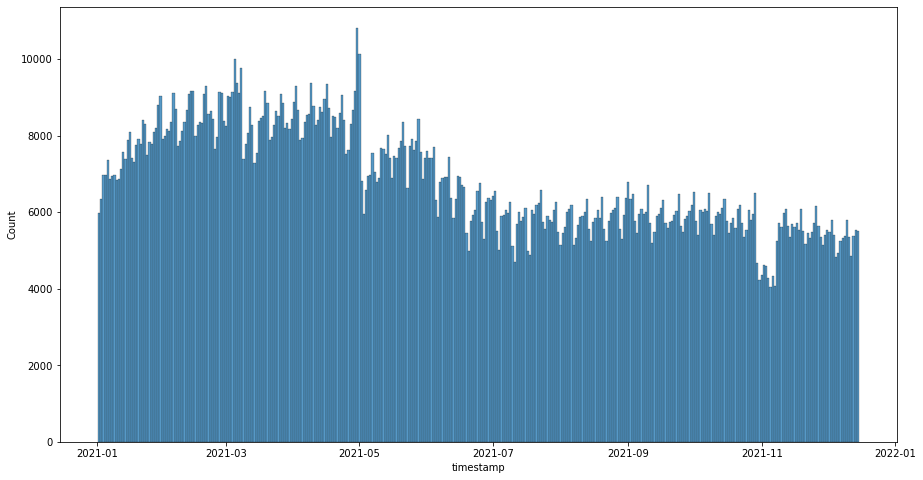

In [53]:
fig,ax = plt.subplots(figsize=(15,8))
sns.histplot(x=df['timestamp'].dt.date,ax=ax)
plt.show()


* Есть пик в районе 2021-05
* "Яма" - 2021-11

**gest_Sum**

In [54]:
describe(df['gest_Sum'])

,gest_Sum
count,2371506.000
mean,452.622
mode,201.600
var,172042.693
stddev,414.780
min,0.000
25%,195.300
50%,340.800
75%,578.200
max,23500.000


* Есть 0. Что они значат?
* Есть ~6% выборосов.

Сколько нулей?

In [55]:
# df['gest_Sum'].value_counts().sort_index()[0:10]
gest_Sum_zeros_count = df['gest_Sum'].value_counts().sort_index()[0]
print(f'Нулей в "gest_Sum": {gest_Sum_zeros_count}')


Нулей в "gest_Sum": 3702


In [56]:
df.loc[df['gest_Sum'] == 0,:].describe()

,gest_Sum,gest_Discount,days_delta
count,3702.000,3702.000,3702.000
mean,0.000,0.000,1.988
std,0.000,0.000,8.182
min,0.000,0.000,-1.000
25%,0.000,0.000,0.000
50%,0.000,0.000,0.000
75%,0.000,0.000,0.000
max,0.000,0.000,196.000


* У всех записей где `'gest_Sum' == 0`, `'gest_Discount'` тоже равен 0.
* Есть даже уникальные клиенты, которые никак в базе не отмечены, кроме такой вот записи с нулями. Об этом говорит значение  `min('days_delta') = -1`, т.е. что это их единственная сделка.

Поскольку эти строки неизвестной природы (отмена заказа ли это, или по какой-то другой причине), то для обучения модели их удалим.

In [57]:
df = df.drop(index=df.loc[df['gest_Sum'] == 0].index)

In [58]:
df.loc[df['gest_Sum'] == 0]

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_delta,delta>=45


Построим гистограмму.

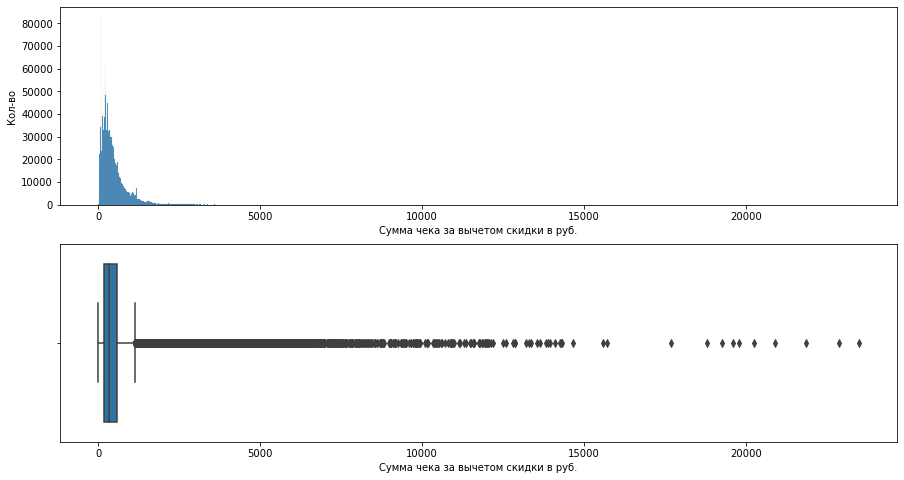

In [59]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
sns.histplot(x=df['gest_Sum'],ax=ax[0],binwidth=10)
sns.boxplot(x=df['gest_Sum'],ax=ax[1])

xlabel = 'Сумма чека за вычетом скидки в руб.'

ax[0].set_ylabel('Кол-во')
ax[0].set_xlabel(xlabel)

ax[1].set_xlabel(xlabel)

plt.show()


Ограничим гистограмму 1500 руб.

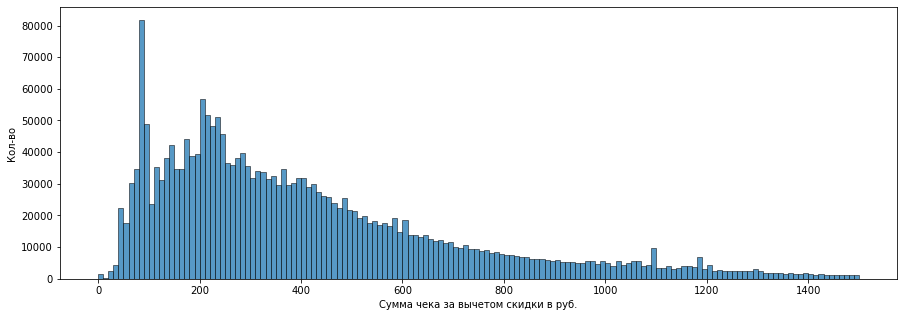

In [60]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.histplot(x=df['gest_Sum'],ax=ax,binwidth=10,binrange=(0,1500))
ax.set_ylabel('Кол-во')
ax.set_xlabel(xlabel)
plt.show()

* Есть пик в районе 100 руб. Кофе?

In [61]:
# Логарифмирование, пока не понимаю зачем оно нужно, и можно ли его как-то интерпретировать
# temp_log = np.log(df['gest_Sum'] + 1)

# fig,ax = plt.subplots(2,1,figsize=(15,8))
# sns.histplot(x=test_log,ax=ax[0])
# sns.boxplot(x=test_log,ax=ax[1])

# xlabel = 'Сумма чека за вычетом скидки в руб.'

# ax[0].set_ylabel('Кол-во')
# ax[0].set_xlabel(xlabel)

# ax[1].set_xlabel(xlabel)

# plt.show()

**gest_Discount**

In [62]:
describe(df['gest_Discount'])

,gest_Discount
count,2367804.000
mean,41.533
mode,0.000
var,7154.001
stddev,84.581
min,0.000
25%,3.200
50%,14.100
75%,44.800
max,3957.500


* Почти 10% выбросов.

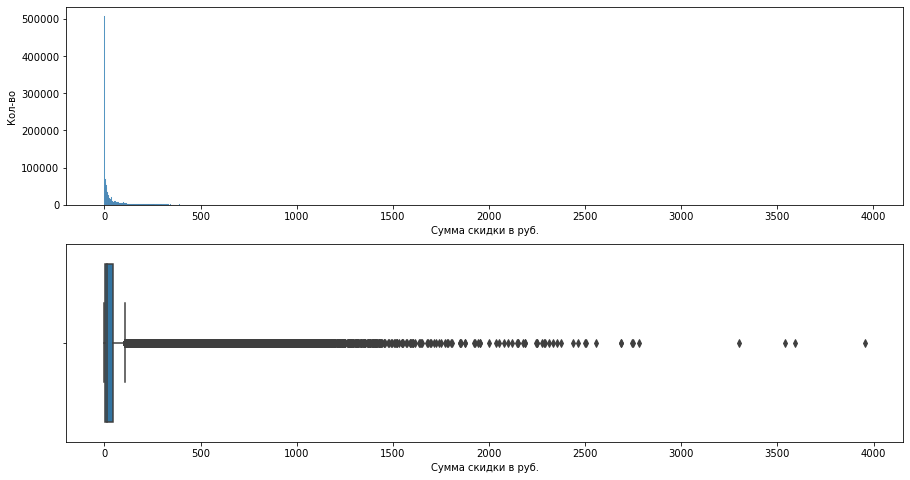

In [63]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
sns.histplot(x=df['gest_Discount'],ax=ax[0],binwidth=1)
sns.boxplot(x=df['gest_Discount'],ax=ax[1])

xlabel = 'Сумма скидки в руб.'

ax[0].set_ylabel('Кол-во')
ax[0].set_xlabel(xlabel)

ax[1].set_xlabel(xlabel)

plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

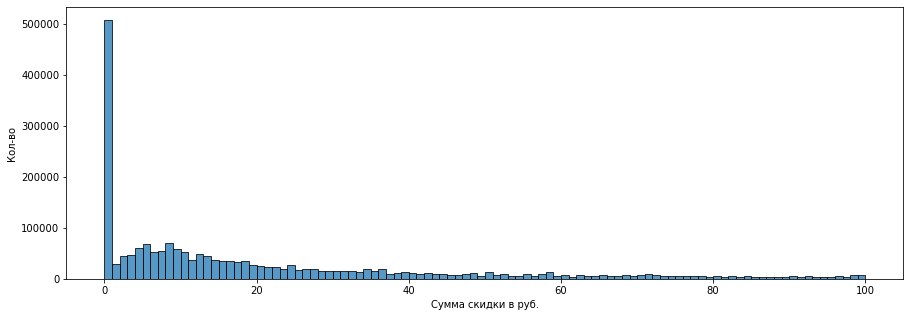

In [64]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
sns.histplot(x=df['gest_Discount'],ax=ax,binwidth=1,binrange=(0,100))
ax.set_ylabel('Кол-во')
ax.set_xlabel(xlabel)
plt.show()
# ДОБАВИТЬ НАЗВАНИЕ ГРАФИКОВ И ОСЕЙ

Посчитаем кол-во скидок равных 0.

In [65]:
pd.concat([df['gest_Discount'].value_counts().iloc[0:5],df['gest_Discount'].value_counts(normalize=True).iloc[0:5]],axis=1)

,gest_Discount,gest_Discount
0.000,506969,0.214
8.400,22558,0.010
9.600,18969,0.008
7.200,18342,0.008
8.800,14287,0.006


In [66]:
gest_Discount_zeros_count = df['gest_Discount'].value_counts()[0]
print(f'Кол-во нулей в "gest_Discount": {gest_Discount_zeros_count}')
gest_Discount_zeros_count = df['gest_Discount'].value_counts(normalize=True)[0]
print(f'Процентов нулей в "gest_Discount" от общего числа: {gest_Discount_zeros_count:.02%}')

Кол-во нулей в "gest_Discount": 506969
Процентов нулей в "gest_Discount" от общего числа: 21.41%


Посмотрим на записи, где скидки равны 0.

In [67]:
df.loc[df['gest_Discount'] == 0].describe()

,gest_Sum,gest_Discount,days_delta
count,506969.000,506969.000,506969.000
mean,541.902,0.000,6.990
std,534.755,0.000,12.417
min,8.000,0.000,-1.000
25%,210.000,0.000,-1.000
50%,385.000,0.000,2.000
75%,698.000,0.000,10.000
max,23500.000,0.000,339.000


Ничего необычного, кроме минимальной суммы чек равной 8 рублям (?!).

## Сравнение признаков с разделение по целевому классу

Поскольку мы не можем воспроизвести логику построения таргета на датасете с чеками, то не можем выделить конкретные сделки, по которым определяется отток.  
Поэтому обозначим все сделки клиента, отнесенного к оттоку, как таргет = 1 для дальнейшего сравнения признаков по таргету.

**Сравнение по стоимости покупки за вычетом скидки: `'gest_Sum'`**

In [68]:
df_eda = df.merge(df_target,on='clnt_ID')
display(df_eda.head())
# df_eda_new = df.merge(df_target_extracted,on='clnt_ID')
# df_eda_new.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_delta,delta>=45,target
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000,300.000,-1.000,False,0
1,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-07 17:09:04.120,393.700,131.300,5.000,False,0
2,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-09 11:49:13.163,817.500,272.500,1.000,False,0
3,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-11 18:38:07.737,337.500,112.500,2.000,False,0
4,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-12 14:53:53.847,180.000,60.000,0.000,False,0


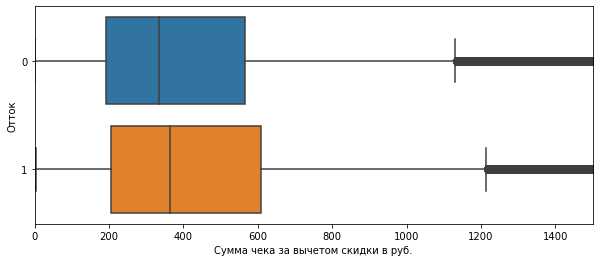

In [69]:

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='gest_Sum', y='target', data=df_eda, ax=ax, orient='h')
ax.set_xlim(0,1500)

xlabel = 'Сумма чека за вычетом скидки в руб.'

ax.set_ylabel('Отток')
ax.set_xlabel(xlabel)

plt.show()

* Сумма чека за вычетом скидки чуть больше у тех, кто уходит в отток, судя по графику. Но нужны статистические тесты для проверки.

**Сравнение по скидке 'gest_Discount'**

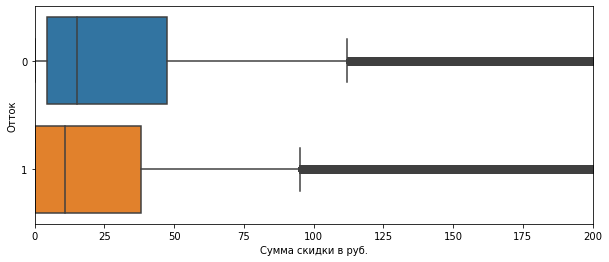

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='gest_Discount', y='target', data=df_eda, ax=ax,orient='h')
ax.set_xlim(0,200)

xlabel = 'Сумма скидки в руб.'

ax.set_ylabel('Отток')
ax.set_xlabel(xlabel)

plt.show()

* У тех, кто остается скидка скорее есть и больше, чем у тех кто уходит в отток.
* У тех, кто уходит в отток - может не быть никакой скидки и она в целом меньше чем у тех, кто остается.

**Сравнение по общей стоимости чека ('gest_Sum'+'gest_Discount')**

Здесь нужно создать столбец с общей стоимостью чека.

In [71]:
df_eda['gest_Total'] = df_eda['gest_Sum'] + df_eda['gest_Discount']
df_eda.head()

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_delta,delta>=45,target,gest_Total
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-02 09:09:17.060,900.000,300.000,-1.000,False,0,1200.000
1,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-07 17:09:04.120,393.700,131.300,5.000,False,0,525.000
2,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-09 11:49:13.163,817.500,272.500,1.000,False,0,1090.000
3,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-11 18:38:07.737,337.500,112.500,2.000,False,0,450.000
4,193B4268-0B4A-475E-B1D0-FF5515E29D29,2021-01-12 14:53:53.847,180.000,60.000,0.000,False,0,240.000


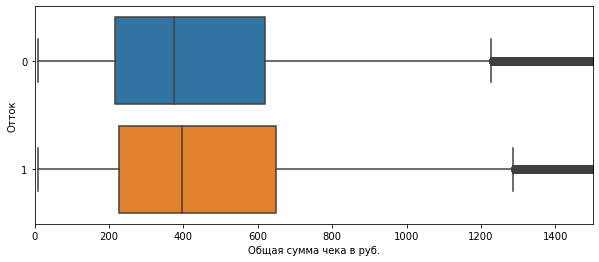

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='gest_Total', y='target', data=df_eda, ax=ax,orient='h')

xlabel = 'Общая сумма чека в руб.'

ax.set_ylabel('Отток')
ax.set_xlabel(xlabel)

ax.set_xlim(0,1500)
plt.show()

* Здесь картина чуть более размазанная, но в целом наблюдаются те же признаки, что и при анализе 'gest_Sum' по таргету.

**Сравнение зависимости gest_Sum от gest_Discount с разделением по таргету**

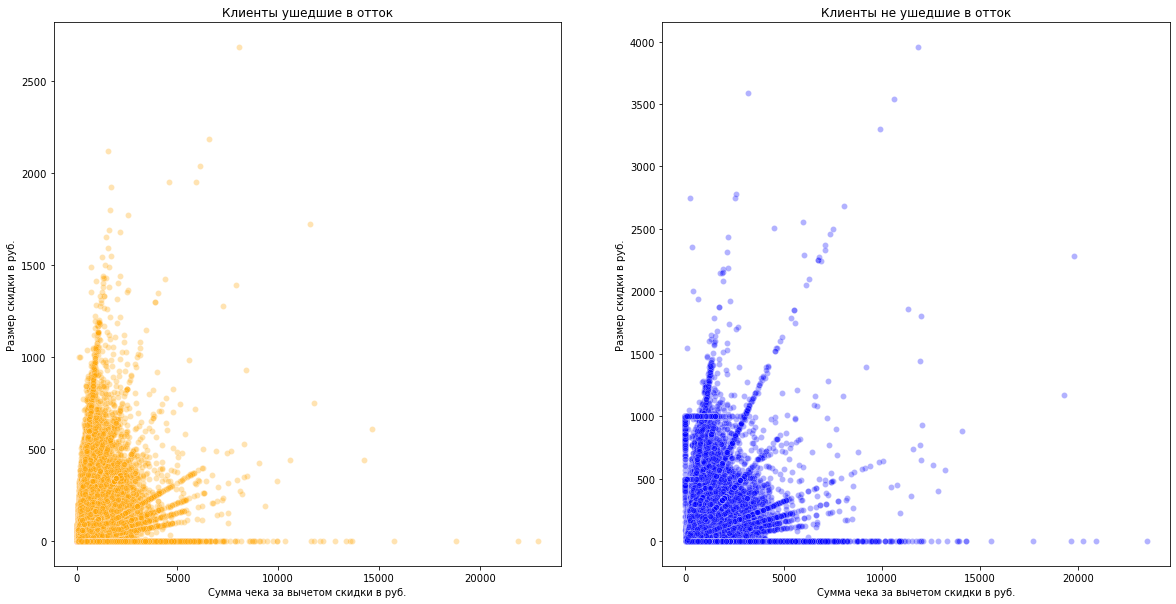

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x="gest_Sum", y="gest_Discount", data=df_eda.loc[df_eda['target'] == 1], alpha=0.3,ax=ax[0],color='orange')
sns.scatterplot(x="gest_Sum", y="gest_Discount", data=df_eda.loc[df_eda['target'] == 0], alpha=0.3,ax=ax[1],color='blue')
ax[0].set_title('Клиенты ушедшие в отток')
ax[0].set_xlabel('Сумма чека за вычетом скидки в руб.')
ax[0].set_ylabel('Размер скидки в руб.')
ax[1].set_title('Клиенты не ушедшие в отток')
ax[1].set_xlabel('Сумма чека за вычетом скидки в руб.')
ax[1].set_ylabel('Размер скидки в руб.')
plt.show()

Похоже есть три типа скидок:
* Фиксированные скидки в % (это прямые линии исходящие из нуля)
* Фиксированные скидки в руб. (акции, купоны или подарочные сертификаты)
* Накопительные баллы (все остальное между)

* У клиентов не ушедших в отток ярко выражены фиксированные скидки в руб. (1000 руб, 500). Возможно, это результат недавней маркетинговой деятельности.

**Сравним кол-во чеков у юзера по таргету**

In [74]:
# pd.concat([df_eda['target'].value_counts(),df_eda['target'].value_counts(normalize=True)],axis=1)
# sns.countplot(x='target',data=df_eda);

In [75]:
buys_count = df_eda.groupby(by=['target','clnt_ID'],as_index=False)['timestamp'].count().loc[:,['target','timestamp']]

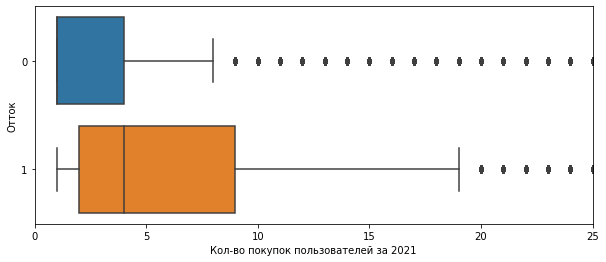

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sns.boxplot(x='timestamp', y='target', data=buys_count, ax=ax,orient='h')
ax.set_xlim(0,25)

xlabel = 'Кол-во покупок пользователей за 2021'

ax.set_ylabel('Отток')
ax.set_xlabel(xlabel)

plt.show()

Те кто ушли в отток, еще не "насытились" продуктом?

**Корреляция**

In [77]:
corr = df_eda.corr()

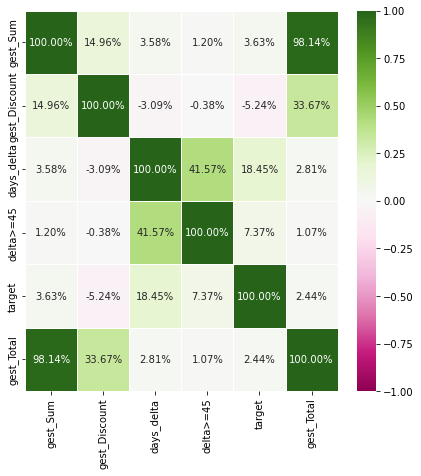

In [78]:
fig,ax = plt.subplots(figsize=(7,7))
sns.heatmap(corr, annot=True,ax=ax,vmin=-1,vmax=1,linewidth=.5,cmap="PiYG",center=0,fmt='.2%')
plt.show()

Чего-то особого, кроме очевидного, здесь не обнаружено.

# BASELINE и model selection

Для бейслайна используем данные в таком виде:  
В КАКОМ?
<!-- * Группируем по клиенту,
* берем общее число покупок
* мин, макс, медиана, среднее, стд отклонение по `gest_Sum`, `gest_Discount`, 
* ~~кол-во дней между покупками, медиана, среднее, стд. отклонение.~~ Кол-во дней между покупками использовать нельзя, потому что это утечка. По среднему и стандартному отклонению можно точно определить был ли хоть раз промежуток в 45 дней между покупками. (И у меня был тут скор ~0.98 из-за этих фичей)
 -->
Модели:
* логистическая регрессия
* дерево решений
* случайный лес

Оцениваем `roc auc` по кроссвалидации на 5 фолдах.

Проверять будем по новому таргету.

In [80]:
df[df['delta>=45'] == True]

,clnt_ID,timestamp,gest_Sum,gest_Discount,days_delta,delta>=45
369769,79683D11-4BFD-4EFE-9A6B-22D2EC17E007,2021-02-18 09:05:03.297,423.200,8.800,45.000,True
387371,8A7D1457-CDC4-4BA8-9F8F-E8009B748241,2021-02-20 09:17:57.393,1524.400,97.600,46.000,True
396747,41FE07CE-6C60-4A76-8DA0-AD261FEFE01D,2021-02-21 10:28:36.223,276.400,135.600,46.000,True
398974,CA5586DB-59C2-44AE-86B5-DF22C6FF9704,2021-02-21 13:14:34.963,120.000,0.000,48.000,True
400880,FEDD2F1B-B62B-4EE1-AD68-B3B09A468189,2021-02-21 15:26:56.520,540.800,11.200,49.000,True
...,...,...,...,...,...,...
2367916,5EEC56A5-2B2C-479E-BB06-DBEEC7E99BC3,2021-12-15 12:43:04.490,342.000,0.000,82.000,True
2368172,40A8BFE1-B0D7-42BD-B10B-5CBAD16E02AE,2021-12-15 13:11:54.833,317.000,48.000,82.000,True
2368381,FA439481-80C9-4B15-B113-87F41057129C,2021-12-15 13:35:33.777,680.000,0.000,136.000,True
2370262,F85C9084-0F74-4CCE-B95F-C4E83920CFD8,2021-12-15 17:57:31.857,340.000,0.000,76.000,True


In [81]:
# Скопируем датасет
df_baseline = df.copy()
df_baseline = df_baseline.drop(columns=['timestamp'])
# df_baseline.head()

,clnt_ID,gest_Sum,gest_Discount,days_delta,delta>=45
0,193B4268-0B4A-475E-B1D0-FF5515E29D29,900.000,300.000,-1.000,False
1,8DA65A37-C1D0-41D4-98E1-AB6C5BF1367F,165.000,55.000,-1.000,False
2,26ACF3C8-25C8-4345-ABC2-33DA15EA6454,800.500,25.500,-1.000,False
3,0F77DDB3-A9A7-44BE-AAAB-9DF59B66A695,580.000,0.000,-1.000,False
4,F16BCF77-FA5A-4093-B7E3-FA86E2B1EA31,148.900,3.100,-1.000,False


In [124]:
# Создадим словарь для функция агрегирования по необходимым столбцам
aggfunc_dict = {'gest_Sum': ['min','max','median','mean',
                             # 'std'
                            ], 
                'gest_Discount': ['min','max','median','mean',
                                  # 'std'
                                 ], 
                # 'clnt_buys_count': ['max','median','mean','std'] # здесь min не нужен, т.к. везде будут 1
               } 

In [125]:
# Сгруппируем по клиентам применим агрегирующие функции из словаря
pivot_baseline = df_baseline.pivot_table(index='clnt_ID', values=['gest_Sum','gest_Discount'],aggfunc=aggfunc_dict, 
                                         # fill_value=0 # Пропуски будут в стандартном отклонении любых признаков, где только 1 покупка
                                        )

In [126]:
pivot_baseline.isna().sum()

gest_Discount  max       0
               mean      0
               median    0
               min       0
gest_Sum       max       0
               mean      0
               median    0
               min       0
dtype: int64

In [85]:
# Уберем мульти-уровни в столбцах
pivot_baseline.columns = ['_'.join(column) for column in pivot_baseline.columns]

In [86]:
pivot_baseline.describe()

,gest_Discount_max,gest_Discount_mean,gest_Discount_median,gest_Discount_min,gest_Sum_max,gest_Sum_mean,gest_Sum_median,gest_Sum_min
count,254621.000,254621.000,254621.000,254621.000,254621.000,254621.000,254621.000,254621.000
mean,96.195,46.293,40.408,31.041,887.082,611.116,588.784,453.094
std,185.629,139.049,139.375,137.831,724.652,539.579,544.901,554.482
min,0.000,0.000,0.000,0.000,0.100,0.100,0.100,0.010
25%,0.000,0.000,0.000,0.000,410.000,296.667,269.600,120.000
50%,27.000,11.333,0.000,0.000,729.800,471.900,439.600,261.800
75%,103.800,39.347,26.650,5.300,1189.000,761.700,740.000,586.500
max,3957.500,2780.500,2780.500,2780.500,23500.000,23500.000,23500.000,23500.000


In [92]:
# Создадим датафрейм с присоединенными таргетами
pivot_baseline_full_new = pivot_baseline.merge(df_target,on='clnt_ID')

In [ ]:
pivot_baseline_full_new.head()

In [93]:
# Уберем айдишники клиентов. Модели они только помешают
pivot_baseline_full_new = pivot_baseline_full_new.drop(columns=['clnt_ID'])


In [94]:
# Создадим фичи и таргет

# Новый
X = pivot_baseline_full_new.drop(columns=['target'])
y = pivot_baseline_full_new['target']

In [95]:
display(X.head())
y.head()

,gest_Discount_max,gest_Discount_mean,gest_Discount_median,gest_Discount_min,gest_Sum_max,gest_Sum_mean,gest_Sum_median,gest_Sum_min
0,44.800,21.800,10.600,10.000,566.200,525.200,519.400,490.000
1,6.000,6.000,6.000,6.000,214.000,214.000,214.000,214.000
2,0.000,0.000,0.000,0.000,470.000,470.000,470.000,470.000
3,280.800,31.657,8.700,3.000,562.600,278.581,261.900,91.200
4,0.000,0.000,0.000,0.000,549.000,549.000,549.000,549.000


0    1
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [96]:
# Логистическая регрессия
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    log_reg = LogisticRegression()
    # log_reg_cv_orig = cross_validate(log_reg, X_orig, y_orig, cv=5, scoring='roc_auc')
    log_reg_cv_new = cross_validate(log_reg, X, y, cv=5, scoring='roc_auc')
    
# Здесь ошибки несходимости - убрал

In [97]:
# Дерево решений
tree = DecisionTreeClassifier()
tree_cv_new = cross_validate(tree,X,y,cv=5,scoring='roc_auc')

In [98]:
# Случайный лес
forest = RandomForestClassifier()
forest_cv_new = cross_validate(forest,X,y,cv=5,scoring='roc_auc')

In [101]:
# Подсчет и вывод метрик

lr_roc_auc = log_reg_cv_new['test_score'].mean()
tree_roc_auc = tree_cv_new['test_score'].mean()
forest_roc_auc = forest_cv_new['test_score'].mean()

scores = {
         'logreg roc auc': lr_roc_auc,
         'tree roc auc': tree_roc_auc,
         'forest roc auc': forest_roc_auc}

for key,value in scores.items():
    print(f'{key} {value:.03f}')

logreg roc auc 0.794
tree roc auc 0.668
forest roc auc 0.862


Подозрительно высокий скор на всех моделях.

In [103]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    log_reg = LogisticRegression().fit(X,y)
log_reg.coef_

array([[-0.00623473,  0.03566106, -0.02246472, -0.01563266, -0.00118583,
         0.00802887, -0.00301547, -0.00622268]])

In [127]:
log_reg.coef_[0]

array([-0.00623473,  0.03566106, -0.02246472, -0.01563266, -0.00118583,
        0.00802887, -0.00301547, -0.00622268])

In [121]:
log_reg.coef_.reshape(-1,1).tolist()

[[-0.006234727136500613],
 [0.035661064491],
 [-0.022464721838930876],
 [-0.01563266114779016],
 [-0.001185831205091738],
 [0.008028871768506583],
 [-0.003015468728221381],
 [-0.006222677726567448]]

In [118]:
log_reg.coef_.tolist()

[[-0.006234727136500613,
  0.035661064491,
  -0.022464721838930876,
  -0.01563266114779016,
  -0.001185831205091738,
  0.008028871768506583,
  -0.003015468728221381,
  -0.006222677726567448]]

In [128]:
list(zip(X.columns,log_reg.coef_[0]))

[('gest_Discount_max', -0.006234727136500613),
 ('gest_Discount_mean', 0.035661064491),
 ('gest_Discount_median', -0.022464721838930876),
 ('gest_Discount_min', -0.01563266114779016),
 ('gest_Sum_max', -0.001185831205091738),
 ('gest_Sum_mean', 0.008028871768506583),
 ('gest_Sum_median', -0.003015468728221381),
 ('gest_Sum_min', -0.006222677726567448)]

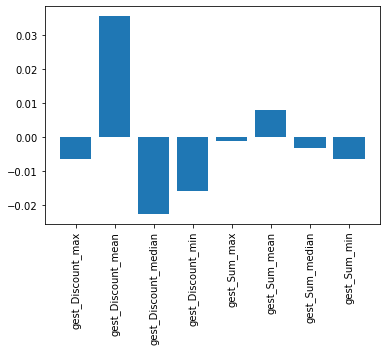

In [129]:
plt.bar(x=X.columns,height=log_reg.coef_[0])
plt.xticks(rotation=90)
plt.show()

In [112]:
forest = RandomForestClassifier(random_state=rand_state).fit(X,y)

In [115]:
list(zip(X.columns,forest.feature_importances_))

[('gest_Discount_max', 0.1219450259581625),
 ('gest_Discount_mean', 0.1005721368706143),
 ('gest_Discount_median', 0.06500639711294946),
 ('gest_Discount_min', 0.08119254405978749),
 ('gest_Sum_max', 0.1800422983697625),
 ('gest_Sum_mean', 0.1360153833495263),
 ('gest_Sum_median', 0.12328468677869865),
 ('gest_Sum_min', 0.19194152750049884)]

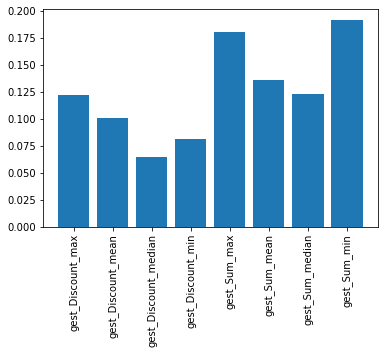

In [116]:
plt.bar(x=X.columns,height=forest.feature_importances_)
plt.xticks(rotation=90)
plt.show()

### catboost -- ON HOLD

In [ ]:
# ON HOLD

# test_data = catboost_pool = Pool(train_data, 
#                                  train_labels)

# model = CatBoostClassifier(iterations=2,
#                            depth=2,
#                            learning_rate=1,
#                            loss_function='Logloss',
#                            verbose=True)
# # train the model
# model.fit(train_data, train_labels)
# # make the prediction using the resulting model
# preds_class = model.predict(test_data)
# preds_proba = model.predict_proba(test_data)
# print("class = ", preds_class)
# print("proba = ", preds_proba)

# Feature engineering

Уже созданы:
* Дельта в днях между ближайшими сделками (-1, если сделка первая) (Исследовать)
* Флаг дельта >= 45 (Исследовать)
* Номер покупки клиента
* Максимальный номер покупки клиента
* Флаг "Клиент сделал всего 1 покупку за всю историю"
* Флаг "Последняя сделка клиента в этих данных при условии, что покупок было больше 1"

Новые фичи.  
Что может помочь лучше предсказать отток клиентов? --ДОПОЛНЯЕТСЯ--

* Общая стоимость заказа без скидки
* Сколько дней на момент сделки прошло с момента первой сделки (сколько дней клиенту)
* Какой на текущий момент средний чек, средняя скидка, средний общая стоимость
* Какая разница между среднем чеком и чеком сделки
* Сколько сделок произошло на момент текущей сделки
* Сколько сделок в месяц в среднем


**Как создавать сложные фичи?**

* Нужно группировать датасет по клиентам
* К этим группам применять разные методы с помощью `.groupby().transform()`

`df.groupby('cnlt_ID').transform(func)`

**Общая стоимость заказа без скидки** = `gest_Sum + gest_Discount`

In [ ]:
df['gest_Total'] = df['gest_Sum'] + df['gest_Discount']

**Сколько дней прошло с первой сделки**

1. Берем min(date)
2. Вычитаем из текущей data min(date) (`df['date'] - df['first_buy_date']`)

In [ ]:
def first_buy_date_delta(col):
    return col - col.min()

df['first_buy_days_delta'] = df.groupby('clnt_ID')['timestamp'].transform(first_buy_date_delta).dt.days

In [ ]:
df.tail()

**TO DO: ИЗУЧИТЬ**

In [ ]:
# df['first_buy_date_delta'].dt.days.astype('int').hist(bins=100)

In [ ]:
# df['first_buy_timestamp_delta'].dt.total_seconds().astype('int').hist(bins=100)

**Какой на текущий момент средний чек, средняя скидка, средний общая стоимость**

Используем `series.expanding().mean()` через `df.groupby('clnt_ID').transform()`.

In [ ]:
def expand_mean(col):
    return col.expanding().mean()

df['clnt_gest_Sum_avg_ongoing'] = df.groupby('clnt_ID')['gest_Sum'].transform(expand_mean)
df['clnt_gest_Discount_avg_ongoing'] = df.groupby('clnt_ID')['gest_Discount'].transform(expand_mean)
df['clnt_gest_Total_avg_ongoing'] = df.groupby('clnt_ID')['gest_Total'].transform(expand_mean)

In [ ]:
df.head()

**TO DO: ИЗУЧИТЬ**

In [ ]:
# df['clnt_gest_Sum_avg'].hist(bins=100)

**Какая разница между средним значением и значением сделки**
Считаем для:
* 'gest_Sum'
* 'gest_Discount'
* 'gest_Total'

`df['gest_Sum'] - df['clnt_gest_Sum_avg_ongoing']`  
`df['gest_Discount'] - df['clnt_gest_Discount_avg_ongoing']`  
`df['gest_Total'] - df['clnt_gest_total_avg_ongoing']`

In [ ]:
df['gest_Sum_delta_from_avg'] = df['gest_Sum'] - df['clnt_gest_Sum_avg_ongoing']
df['gest_Discount_delta_from_avg'] = df['gest_Discount'] - df['clnt_gest_Discount_avg_ongoing']
df['gest_total_delta_from_avg'] = df['gest_Total'] - df['clnt_gest_Total_avg_ongoing']

In [ ]:
df.tail()

**TO DO: ИЗУЧИТЬ**

In [ ]:
# df['gest_total_delta_from_avg'].hist(bins=100)

**Сколько сделок произошло на момент текущей сделки**  
`series.expanding().count()`

In [ ]:
def expand_count(col):
    return col.expanding().count()

df['clnt_buys_count'] = df.groupby('clnt_ID')['timestamp'].transform(expand_count)

In [ ]:
df.tail()

**TO DO: ИЗУЧИТЬ**

In [ ]:
# df['clnt_buys_count'].describe()

In [ ]:
# df['clnt_buys_count'].hist(bins=100)

# Model tuning

EMPTY